In [13]:
# --- INSTALL & IMPORT ---
# Cài đặt các thư viện cần thiết (chạy 1 lần)
!pip install -q datasets scikit-learn seaborn matplotlib joblib kagglehub plotly

import re

import kagglehub
import numpy as np
import pandas as pd

# Cấu hình hiển thị Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# --- LOAD DATA ---
print("🔽 Đang tải dữ liệu từ Kaggle...")
path = kagglehub.dataset_download("arshkon/linkedin-job-postings")
print(f"📂 Đường dẫn dữ liệu: {path}")

# Đọc file CSV
df_posting = pd.read_csv(f'{path}/postings.csv')

# Kiểm tra nhanh cấu trúc
print(f"📊 Kích thước dữ liệu gốc: {df_posting.shape}")
df_posting.info()


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


🔽 Đang tải dữ liệu từ Kaggle...
📂 Đường dẫn dữ liệu: C:\Users\longh\.cache\kagglehub\datasets\arshkon\linkedin-job-postings\versions\13
📊 Kích thước dữ liệu gốc: (123849, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary   

## 1. Kiểm tra và Đánh giá "Sức khỏe" Dữ liệu (Data Health Check)

Trước khi đi vào xử lý, chúng ta cần xác định mức độ thiếu hụt thông tin của bộ dữ liệu.
* **Mục tiêu:** Xác định các cột quan trọng có quá nhiều giá trị Null để cảnh báo hoặc loại bỏ.
* **Logic:** Tính tỷ lệ % missing value cho từng cột và sắp xếp giảm dần.

In [14]:
# Tính phần trăm missing value cho từng cột
missing_percent = df_posting.isnull().mean() * 100

# Lọc và chỉ hiển thị các cột có dữ liệu bị thiếu > 0%
missing_data = missing_percent[missing_percent > 0].sort_values(ascending=False).to_frame(name='% Missing')

print("--- 📉 Bảng Tỷ lệ Dữ liệu bị thiếu ---")
display(missing_data.head(15)) # Xem top 15 cột thiếu nhiều nhất

# Kiểm tra nhanh các cột định danh (Categorical) xem có giá trị lạ không
cols_to_check = ['formatted_work_type', 'pay_period', 'currency']
for col in cols_to_check:
    print(f"\n>> Phân phối giá trị cột: {col}")
    print(df_posting[col].value_counts(dropna=False))

--- 📉 Bảng Tỷ lệ Dữ liệu bị thiếu ---


,% Missing
closed_time,99.13
skills_desc,98.03
med_salary,94.93
remote_allowed,87.69
applies,81.17
min_salary,75.94
max_salary,75.94
pay_period,70.87
compensation_type,70.87
normalized_salary,70.87



>> Phân phối giá trị cột: formatted_work_type
formatted_work_type
Full-time     98814
Contract      12117
Part-time      9696
Temporary      1190
Internship      983
Volunteer       562
Other           487
Name: count, dtype: int64

>> Phân phối giá trị cột: pay_period
pay_period
NaN         87776
YEARLY      20628
HOURLY      14741
MONTHLY       518
WEEKLY        177
BIWEEKLY        9
Name: count, dtype: int64

>> Phân phối giá trị cột: currency
currency
NaN    87776
USD    36058
EUR        6
CAD        3
BBD        2
AUD        2
GBP        2
Name: count, dtype: int64


In [15]:
# Hiển thị 5 dòng ngẫu nhiên
display(df_posting.sample(5))

# Kiểm tra tỷ lệ missing value
print("\n--- ⚠️ Tỷ lệ dữ liệu bị thiếu (%) ---")
missing_percent = df_posting.isnull().mean() * 100
print(missing_percent[missing_percent > 0].sort_values(ascending=False).head(10))

# Kiểm tra thống kê các cột số quan trọng
print("\n--- 📈 Thống kê mô tả sơ bộ ---")
display(df_posting[['max_salary', 'min_salary', 'views', 'applies']].describe())

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
74979,3903444449,Circana,Client Insights Consultant I,Client Insights Consultant\n\nLet’s be unstopp...,NaN,NaN,United States,93158430.00,32.00,NaN,NaN,Full-time,NaN,1713398400000.00,1.00,https://www.linkedin.com/jobs/view/3903444449/...,https://recruiting2.ultipro.com/INF1019IRINC/J...,OffsiteApply,1716045961000.00,NaN,Mid-Senior level,NaN,1713453961000.00,recruiting2.ultipro.com,0,FULL_TIME,NaN,NaN,NaN,NaN,NaN
92272,3904579484,Capital One,"Senior Manager, Product Management, Associate ...","West Creek 1 (12071), United States of America...",NaN,NaN,"Richmond, VA",1419.00,4.00,NaN,NaN,Full-time,NaN,1713554047000.00,NaN,https://www.linkedin.com/jobs/view/3904579484/...,https://dsp.prng.co/Ko7V7jb,OffsiteApply,1716146758000.00,NaN,Mid-Senior level,NaN,1713554758000.00,dsp.prng.co,0,FULL_TIME,NaN,NaN,NaN,23219.00,51760.00
80681,3903843573,Eddie Bauer,Part-Time Stock Associate - Spokane Valley 4190,Overview\n\nOur Stock Associates will control ...,NaN,NaN,"Spokane Valley, Washington, United States",157346.00,4.00,NaN,NaN,Part-time,NaN,1713479989000.00,NaN,https://www.linkedin.com/jobs/view/3903843573/...,https://retailus-eddiebauer-sparcgroup.icims.c...,OffsiteApply,1716073731000.00,NaN,Entry level,NaN,1713481731000.00,retailus-eddiebauer-sparcgroup.icims.com,0,PART_TIME,NaN,NaN,NaN,NaN,NaN
94953,3904920726,"Maplewood, New Jersey",Environmental Health Specialist,Maplewood Township is seeking a full-time Regi...,NaN,NaN,"Maplewood, NJ",73829234.00,4.00,NaN,NaN,Full-time,NaN,1713448952000.00,NaN,https://www.linkedin.com/jobs/view/3904920726/...,NaN,ComplexOnsiteApply,1716040952000.00,NaN,NaN,NaN,1713448952000.00,NaN,0,FULL_TIME,NaN,NaN,NaN,7040.00,34013.00
27252,3891268979,"Mitsubishi HC Capital America, Inc.","Vice President, Business Development - Invent",We will consider candidates near our Flower Mo...,NaN,NaN,"Flower Mound, TX",75644973.00,5.00,NaN,NaN,Full-time,NaN,1712793600000.00,NaN,https://www.linkedin.com/jobs/view/3891268979/...,https://workforcenow.adp.com/mascsr/default/md...,OffsiteApply,1715483626000.00,NaN,Executive,NaN,1712891626000.00,workforcenow.adp.com,0,FULL_TIME,NaN,NaN,NaN,75022.00,NaN



--- ⚠️ Tỷ lệ dữ liệu bị thiếu (%) ---
closed_time         99.13
skills_desc         98.03
med_salary          94.93
remote_allowed      87.69
applies             81.17
min_salary          75.94
max_salary          75.94
pay_period          70.87
compensation_type   70.87
normalized_salary   70.87
dtype: float64

--- 📈 Thống kê mô tả sơ bộ ---


,max_salary,min_salary,views,applies
count,29793.00,29793.00,122160.00,23320.00
mean,91939.42,64910.85,14.62,10.59
std,701110.14,495973.79,85.90,29.05
min,1.00,1.00,1.00,1.00
25%,48.28,37.00,3.00,1.00
50%,80000.00,60000.00,4.00,3.00
75%,140000.00,100000.00,8.00,8.00
max,120000000.00,85000000.00,9975.00,967.00


In [16]:
# Tạo bản sao để xử lý
df_clean = df_posting.copy()

## 2. Xử lý Dữ liệu Trùng lặp (Data Deduplication)

Trong dữ liệu tuyển dụng, các công ty thường xuyên đăng lại (repost) cùng một công việc để bài đăng luôn hiển thị ở trang đầu. Điều này dẫn đến việc thống kê bị sai lệch (số lượng việc làm ảo tăng cao).

**Chiến lược xử lý:**
1.  **Sắp xếp thời gian:** Đưa các bài đăng mới nhất lên đầu.
2.  **Khử trùng lặp:** Loại bỏ các dòng bị trùng lặp dựa trên bộ ba thông tin: `company_name` (Tên công ty), `title` (Tiêu đề) và `description` (Mô tả công việc).
3.  **Giữ lại:** Chỉ giữ lại bài đăng mới nhất (first).

In [17]:
# Tạo bản sao để xử lý
df_clean = df_posting.copy()

# 1. Chuyển đổi thời gian
df_clean['listed_time'] = pd.to_datetime(df_clean['listed_time'], unit='ms')

# 2. Thống kê trước khi xóa
print(f"Số lượng dòng ban đầu: {len(df_clean):,}")

# 3. Sắp xếp để ưu tiên bài đăng mới nhất
df_clean = df_clean.sort_values('listed_time', ascending=False)

# 4. Xóa trùng lặp (Logic khắt khe: Trùng cả Tên cty, Tiêu đề và Mô tả)
df_clean = df_clean.drop_duplicates(subset=['company_name', 'title', 'description'], keep='first')

print(f"Số lượng dòng sau khi làm sạch: {len(df_clean):,}")
print(f"--> Đã loại bỏ: {len(df_posting) - len(df_clean):,} dòng trùng lặp.")

Số lượng dòng ban đầu: 123,849
Số lượng dòng sau khi làm sạch: 111,199
--> Đã loại bỏ: 12,650 dòng trùng lặp.


## 3. Tính toán và Chuẩn hóa Lương (Advanced Salary Logic)

Dữ liệu lương rất phức tạp với nhiều kỳ hạn trả (Giờ, Tháng, Năm) và hình thức làm việc (Full-time, Part-time). Chúng ta áp dụng logic sau:

**Bước 1: Xác định Lương Trung bình Thô (`avg_salary_raw`)**
* Ưu tiên lấy `med_salary` (lương trung vị) nếu có.
* Nếu không, tính trung bình cộng của `min_salary` và `max_salary`.

**Bước 2: Quy đổi về Lương Năm (`yearly_salary`)**
* Xác định số giờ làm việc chuẩn:
    * **Part-time:** Giả định 20 giờ/tuần.
    * **Full-time/Khác:** Giả định 40 giờ/tuần.
* Công thức quy đổi:
    * `HOURLY`: Lương * Giờ/tuần * 52 tuần.
    * `WEEKLY`: Lương * 52 tuần.
    * `MONTHLY`: Lương * 12 tháng.
    * `BIWEEKLY`: Lương * 26 kỳ (nếu có).

In [18]:
import numpy as np

# --- Bước 1: Tính Lương cơ sở (Base Salary) ---
def calculate_base_salary(row):
    # Ưu tiên Med Salary vì nó chính xác hơn Min/Max
    if pd.notna(row['med_salary']):
        return row['med_salary']
    # Nếu không có Med, dùng trung bình Min-Max
    elif pd.notna(row['min_salary']) and pd.notna(row['max_salary']):
        return (row['min_salary'] + row['max_salary']) / 2
    else:
        return np.nan

df_clean['avg_salary_raw'] = df_clean.apply(calculate_base_salary, axis=1)

# --- Bước 2: Logic Quy đổi Nâng cao (Normalization) ---
def advanced_normalization(row):
    salary = row['avg_salary_raw']
    period = str(row['pay_period']).upper()
    work_type = str(row['work_type']).upper()

    if pd.isna(salary): return np.nan

    # Logic xử lý số giờ làm việc (Logic này thường bị bỏ qua nhưng rất quan trọng)
    hours_per_week = 40
    if 'PART' in work_type: # Nếu là Part-time
        hours_per_week = 20

    # Quy đổi dựa trên kỳ hạn
    if 'HOUR' in period:
        return salary * hours_per_week * 52
    elif 'MONTH' in period:
        return salary * 12
    elif 'WEEK' in period:
        return salary * 52
    elif 'YEAR' in period:
        return salary

    return salary # Fallback

df_clean['yearly_salary'] = df_clean.apply(advanced_normalization, axis=1)

# Xử lý riêng cho trường hợp Bi-weekly (nếu dữ liệu bị lẫn trong Weekly hoặc cột khác)
# Một số dữ liệu text ghi 'Bi-weekly' nhưng pay_period lại là code khác, cần check kỹ
mask_biweekly = df_clean['pay_period'].astype(str).str.contains('BIWEEKLY', case=False, na=False)
if mask_biweekly.sum() > 0:
    print(f"⚠️ Phát hiện {mask_biweekly.sum()} bản ghi Bi-weekly, đang điều chỉnh...")
    df_clean.loc[mask_biweekly, 'yearly_salary'] = df_clean.loc[mask_biweekly, 'avg_salary_raw'] * 26

# Hiển thị kết quả kiểm tra ngẫu nhiên
display(df_clean[['title', 'work_type', 'pay_period', 'avg_salary_raw', 'yearly_salary']].dropna().sample(5))

⚠️ Phát hiện 7 bản ghi Bi-weekly, đang điều chỉnh...


,title,work_type,pay_period,avg_salary_raw,yearly_salary
64343,Gas Appliance Sales Representative,FULL_TIME,HOURLY,15.00,31200.00
21791,Cloud Computing systems Engineer,FULL_TIME,YEARLY,108299.86,108299.86
27622,Business Office Manager,FULL_TIME,HOURLY,28.98,60268.00
309,Community Association Manager- Portfolio,FULL_TIME,YEARLY,49000.00,49000.00
114649,Filtration Product Development Manager,FULL_TIME,YEARLY,135000.00,135000.00


## 4. Lọc Dữ liệu Nhiễu (Filtering & Outliers)

Sau khi tính toán, chúng ta cần loại bỏ các giá trị bất thường (Outliers) để đảm bảo độ chính xác cho biểu đồ thống kê.

**Các tiêu chí lọc:**
1.  **Tiền tệ:** Chỉ giữ lại `USD`.
2.  **Khoảng lương hợp lý:**
    * **Sàn (Min):** $15,000/năm (Dưới mức này thường là lỗi hoặc thực tập không lương).
    * **Trần (Max):** $600,000/năm (Trên mức này thường là nhiễu hoặc các vị trí C-level cực hiếm, gây lệch biểu đồ).

--- Trước khi lọc Outliers ---
count       34188.00
mean       188774.60
std       4734601.05
min             0.00
25%         50960.00
50%         80000.00
75%        124800.00
max     535600000.00
Name: yearly_salary, dtype: float64

--- Sau khi lọc Outliers (Final Data) ---
Số lượng bản ghi sạch: 33,539
count    33539.00
mean     95179.64
std      58556.21
min      15000.00
25%      52000.00
50%      82160.00
75%     124800.00
max     600000.00
Name: yearly_salary, dtype: float64


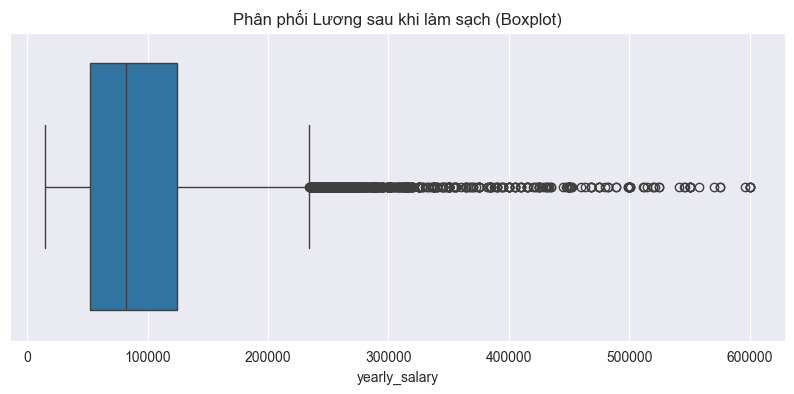

In [19]:
# Thống kê trước khi lọc
print("--- Trước khi lọc Outliers ---")
print(df_clean['yearly_salary'].describe())

# Tạo bộ lọc (Mask)
mask_clean = (
    (df_clean['yearly_salary'].notnull()) &      # Phải có lương
    (df_clean['currency'] == 'USD') &            # Chỉ lấy USD
    (df_clean['yearly_salary'] >= 15000) &       # Min threshold
    (df_clean['yearly_salary'] <= 600000)        # Max threshold
)

df_final = df_clean[mask_clean].copy()

print("\n--- Sau khi lọc Outliers (Final Data) ---")
print(f"Số lượng bản ghi sạch: {len(df_final):,}")
print(df_final['yearly_salary'].describe())

# Vẽ biểu đồ Boxplot để kiểm tra phân phối sau khi lọc
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.boxplot(x=df_final['yearly_salary'])
plt.title('Phân phối Lương sau khi làm sạch (Boxplot)')
plt.show()

## 5. Feature Engineering: Địa điểm và Thời gian

Để phục vụ phân tích sâu hơn (EDA), chúng ta cần trích xuất thêm thông tin từ các cột thô:

* **Location:** Cột `location` thường có dạng "City, State". Chúng ta sẽ tách lấy mã **State** (ví dụ: CA, NY, TX) để phân tích theo vùng địa lý.
* **Time:** Tách `listed_time` thành Ngày trong tuần, Tháng, Giờ đăng để tìm hiểu hành vi đăng tuyển của nhà tuyển dụng.

In [20]:
# 1. Trích xuất Bang (State)
def extract_state(location):
    if pd.isna(location): return 'Unknown'
    if ',' in location:
        state = location.split(',')[-1].strip()
        # Chỉ lấy mã bang 2 ký tự viết hoa (chuẩn Mỹ)
        if len(state) == 2 and state.isupper():
            return state
    return 'Other'

df_final['job_state'] = df_final['location'].apply(extract_state)

# 2. Trích xuất Thời gian
df_final['post_month'] = df_final['listed_time'].dt.month
df_final['post_day_name'] = df_final['listed_time'].dt.day_name()

print("✅ Mẫu dữ liệu sau khi trích xuất đặc trưng:")
display(df_final[['location', 'job_state', 'listed_time', 'post_day_name']].head())

✅ Mẫu dữ liệu sau khi trích xuất đặc trưng:


,location,job_state,listed_time,post_day_name
72041,"Fort Worth, TX",TX,2024-04-20 00:26:56,Saturday
72746,"Bismarck, ND",ND,2024-04-20 00:26:43,Saturday
123837,"Irvine, CA",CA,2024-04-20 00:26:30,Saturday
72649,"Vancouver, WA",WA,2024-04-20 00:26:28,Saturday
72566,United States,Other,2024-04-20 00:26:25,Saturday


## 5. Text Mining: Trích xuất Kỹ năng từ Mô tả

Sử dụng kỹ thuật **Regex (Biểu thức chính quy)** để quét cột `description` và tìm kiếm sự xuất hiện của các công cụ/ngôn ngữ lập trình phổ biến.

*Lưu ý: Phương pháp này chỉ tìm kiếm từ khóa chính xác, không hiểu ngữ cảnh.*

In [21]:
import re

# Định nghĩa từ điển kỹ năng cần tìm
target_skills = {
    'Python': r'\bPYTHON\b',
    'SQL': r'\bSQL\b',
    'Excel': r'\bEXCEL\b',
    'Tableau': r'\bTABLEAU\b',
    'Power BI': r'\bPOWER BI\b',
    'AWS': r'\bAWS\b|AMAZON WEB SERVICES',
    'Java': r'\bJAVA\b', # \b để tránh bắt nhầm 'Javascript'
    'R': r'\bR\b'        # \b để tránh bắt nhầm chữ cái R trong từ khác
}

def extract_skills_regex(text, skill_dict):
    if pd.isna(text): return []
    text_upper = text.upper()
    found_skills = []
    for skill, pattern in skill_dict.items():
        if re.search(pattern, text_upper):
            found_skills.append(skill)
    return found_skills

# Áp dụng vào DataFrame
df_final['extracted_skills'] = df_final['description'].apply(lambda x: extract_skills_regex(x, target_skills))

print("✅ Đã trích xuất kỹ năng xong.")
# Hiển thị thử 5 dòng có kỹ năng
display(df_final[['title', 'extracted_skills']].head())

✅ Đã trích xuất kỹ năng xong.


,title,extracted_skills
72041,Warehouse Associate WMS 3W,[]
72746,Project Estimator/Manager,[]
123837,Contract Administrator,[Excel]
72649,Senior Systems Administrator,[Python]
72566,Finance Systems and Process Change Management ...,[]


In [22]:
# 1. TRÍCH XUẤT BANG (STATE)
def extract_state(location):
    if pd.isna(location): return 'Unknown'
    if ',' in location:
        state = location.split(',')[-1].strip()
        if len(state) == 2 and state.isupper(): return state
    return 'Other'

df_clean['job_state'] = df_clean['location'].apply(extract_state)

# 2. TRÍCH XUẤT KỸ NĂNG (SKILLS EXTRACTION)
# Định nghĩa từ điển kỹ năng với Regex để bắt chính xác hơn
skills_dict = {
    'Python': r'\bPYTHON\b',
    'SQL': r'\bSQL\b',
    'Excel': r'\bEXCEL\b',
    'Tableau': r'\bTABLEAU\b',
    'Power BI': r'\bPOWER BI\b',
    'AWS': r'\bAWS\b|AMAZON WEB SERVICES',
    'Java': r'\bJAVA\b',
    'C++': r'\bC\+\+\b',
    'Machine Learning': r'\bMACHINE LEARNING\b',
    'Spark': r'\bSPARK\b'
}

def extract_skills(text, skill_map):
    if pd.isna(text): return []
    text_upper = text.upper()
    return [skill for skill, pattern in skill_map.items() if re.search(pattern, text_upper)]

# Áp dụng
df_clean['extracted_skills'] = df_clean['description'].apply(lambda x: extract_skills(x, skills_dict))

print("✅ Đã trích xuất xong Bang và Kỹ năng.")

✅ Đã trích xuất xong Bang và Kỹ năng.


In [23]:
# 1. Thống kê Lương theo Cấp bậc
order_exp = ['Internship', 'Entry level', 'Associate', 'Mid-Senior level', 'Director', 'Executive']
exp_stats = df_clean.groupby('formatted_experience_level')['yearly_salary'].describe().reindex(order_exp)

print("### 📊 Mức lương theo Cấp bậc Kinh nghiệm (USD/Năm) ###")
display(exp_stats.style.background_gradient(cmap='Greens', subset=['50%', 'mean']))

# 2. So sánh Remote vs On-site
df_clean['work_mode'] = df_clean['remote_allowed'].apply(lambda x: 'Remote' if x == 1 else 'On-site')
remote_stats = df_clean.groupby('work_mode')['yearly_salary'].agg(['count', 'median', 'mean']).round(0)

print("\n### 🏠 So sánh Remote vs On-site ###")
display(remote_stats)

### 📊 Mức lương theo Cấp bậc Kinh nghiệm (USD/Năm) ###


,count,mean,std,min,25%,50%,75%,max
formatted_experience_level,,,,,,,,
Internship,353.000000,694127.729419,5391172.993187,15.000000,39520.000000,46800.000000,58614.400000,47179392.000000
Entry level,8482.000000,254709.555808,6921116.122800,15.895000,39002.600000,52000.000000,76500.000000,535600000.000000
Associate,3719.000000,81493.158379,48310.790834,1.500000,55000.000000,72800.000000,97805.000000,1200000.000000
Mid-Senior level,12216.000000,178592.509799,4375012.632927,0.000000,75000.000000,107000.000000,140000.000000,362408800.000000
Director,1207.000000,171492.842461,70081.965781,1.000000,130000.000000,165000.000000,205000.000000,750000.000000
Executive,357.000000,203499.328880,98791.003734,212.500000,140500.000000,196100.000000,250000.000000,631800.000000



### 🏠 So sánh Remote vs On-site ###


,count,median,mean
work_mode,,,
On-site,29647,76960.00,199465.00
Remote,4541,110000.00,118977.00


In [24]:
# 1. Top 10 Công việc Lương cao nhất (Có ít nhất 10 bài đăng)
job_stats = df_clean.groupby('title').agg(
    median_salary=('yearly_salary', 'median'),
    posting_count=('title', 'count')
).reset_index()

top_jobs = job_stats[job_stats['posting_count'] >= 10].sort_values('median_salary', ascending=False).head(10)
print("### 🏆 Top 10 Job Title có Lương trung vị cao nhất ###")
display(top_jobs)

# 2. ROI của Kỹ năng (Kỹ năng nào mang lại lương cao?)
skill_data = []
for skill in skills_dict.keys():
    # Lọc các dòng có chứa kỹ năng này
    mask = df_clean['extracted_skills'].apply(lambda x: skill in x)
    if mask.sum() > 0:
        salary = df_clean[mask]['yearly_salary'].median()
        count = mask.sum()
        skill_data.append({'Skill': skill, 'Median_Salary': salary, 'Job_Count': count})

df_skill_roi = pd.DataFrame(skill_data).sort_values('Median_Salary', ascending=False)
print("\n### 💰 Giá trị thị trường của từng Kỹ năng (Median Salary) ###")
display(df_skill_roi)

### 🏆 Top 10 Job Title có Lương trung vị cao nhất ###


,title,median_salary,posting_count
47794,Psychiatrist,275000.00,15
36914,Medical Doctor,264249.50,10
38804,New Home Sales Consultant,262500.00,14
16591,Dentist,260000.00,34
10680,Chief Financial Officer,250000.00,47
31374,Labor And Employment Attorney,230000.00,11
36890,Medical Director,225000.00,13
70222,Vice President Finance,225000.00,13
25262,General Dentist,225000.00,12
45095,Primary Care Physician,225000.00,18



### 💰 Giá trị thị trường của từng Kỹ năng (Median Salary) ###


,Skill,Median_Salary,Job_Count
7,C++,172975.00,100
8,Machine Learning,162960.00,1503
5,AWS,142900.00,2965
6,Java,141875.00,2466
9,Spark,141500.00,779
0,Python,140000.00,4159
1,SQL,123649.50,4686
3,Tableau,115000.00,1169
4,Power BI,110120.00,1013
2,Excel,80000.00,16742
